In [ ]:
!git clone https://github.com/cdancette/deep-learning-polytech-tp6-7.git

In [2]:
cd deep-learning-polytech-tp6-7

/home/yunfei/Desktop/m2a_sorbonne/TP/rdfia/TP05-06/deep-learning-polytech-tp6-7


In [3]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tme6 import *

PRINT_INTERVAL = 200
PATH="datasets"

In [4]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, (5, 5), stride=1, padding=2),
            nn.Tanh(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(6, 16, (5, 5), stride=1, padding=0),
            nn.Tanh(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(400, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.MNIST(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    val_dataset = datasets.MNIST(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


0.3%

31.0%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

79.8%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100.0%


Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw


102.8%


Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw




100.0%
112.7%
/home/yunfei/anaconda3/envs/RLD/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630815121/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw

Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw

=== EPOCH 1 =====

[TRAIN Batch 000/469]	Time 0.522s (0.522s)	Loss 2.3062 (2.3062)	Prec@1   7.0 (  7.0)	Prec@5  50.8 ( 50.8)


<Figure size 432x288 with 0 Axes>

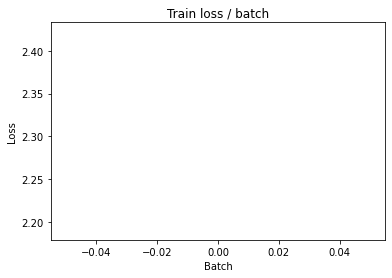

[TRAIN Batch 200/469]	Time 0.021s (0.012s)	Loss 0.3524 (1.0752)	Prec@1  89.8 ( 70.5)	Prec@5 100.0 ( 92.1)


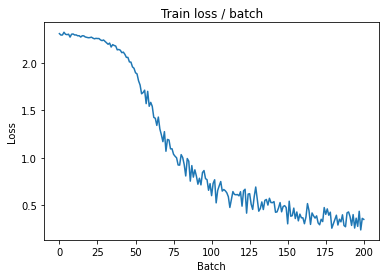

[TRAIN Batch 400/469]	Time 0.005s (0.011s)	Loss 0.2402 (0.6602)	Prec@1  95.3 ( 81.8)	Prec@5  99.2 ( 95.9)


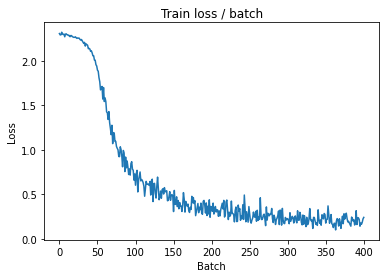


===============> Total time 4s	Avg loss 0.5895	Avg Prec@1 83.70 %	Avg Prec@5 96.45 %

[EVAL Batch 000/079]	Time 0.076s (0.076s)	Loss 0.1183 (0.1183)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)

===============> Total time 0s	Avg loss 0.1561	Avg Prec@1 95.26 %	Avg Prec@5 99.94 %



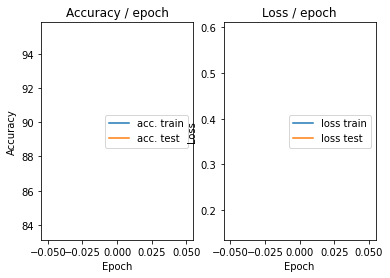

=== EPOCH 2 =====

[TRAIN Batch 000/469]	Time 0.080s (0.080s)	Loss 0.1080 (0.1080)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


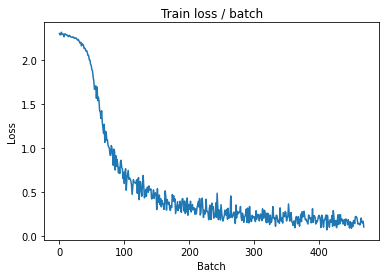

[TRAIN Batch 200/469]	Time 0.009s (0.007s)	Loss 0.0463 (0.1378)	Prec@1  99.2 ( 96.0)	Prec@5 100.0 ( 99.9)


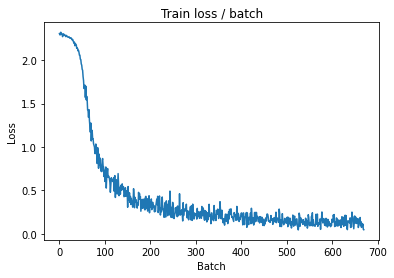

[TRAIN Batch 400/469]	Time 0.009s (0.007s)	Loss 0.0883 (0.1219)	Prec@1  96.9 ( 96.4)	Prec@5 100.0 ( 99.9)


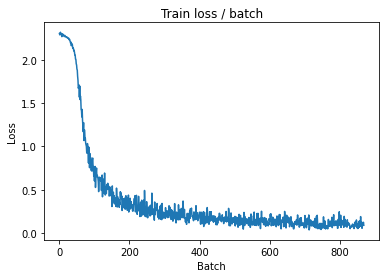


===============> Total time 3s	Avg loss 0.1188	Avg Prec@1 96.55 %	Avg Prec@5 99.92 %

[EVAL Batch 000/079]	Time 0.068s (0.068s)	Loss 0.0418 (0.0418)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)

===============> Total time 0s	Avg loss 0.0797	Avg Prec@1 97.61 %	Avg Prec@5 99.98 %



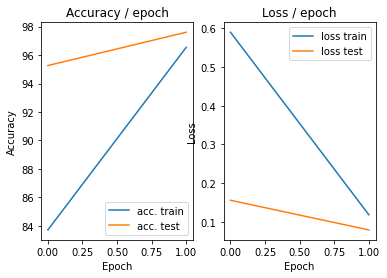

=== EPOCH 3 =====

[TRAIN Batch 000/469]	Time 0.073s (0.073s)	Loss 0.0574 (0.0574)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


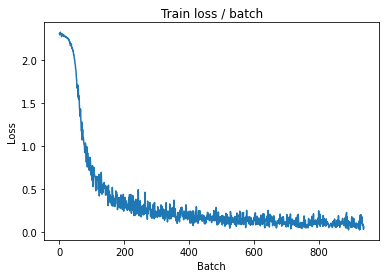

[TRAIN Batch 200/469]	Time 0.004s (0.008s)	Loss 0.0727 (0.0831)	Prec@1  97.7 ( 97.6)	Prec@5 100.0 ( 99.9)


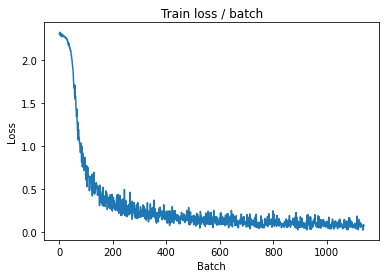

[TRAIN Batch 400/469]	Time 0.007s (0.008s)	Loss 0.0774 (0.0795)	Prec@1  96.1 ( 97.7)	Prec@5 100.0 ( 99.9)


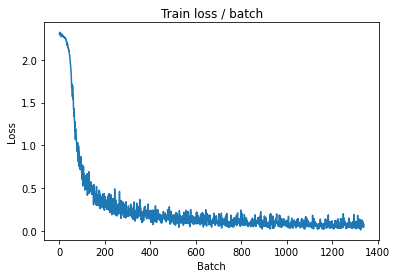


===============> Total time 3s	Avg loss 0.0791	Avg Prec@1 97.65 %	Avg Prec@5 99.95 %

[EVAL Batch 000/079]	Time 0.140s (0.140s)	Loss 0.0184 (0.0184)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)

===============> Total time 0s	Avg loss 0.0567	Avg Prec@1 98.15 %	Avg Prec@5 100.00 %



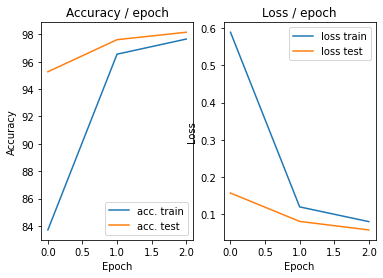

=== EPOCH 4 =====

[TRAIN Batch 000/469]	Time 0.074s (0.074s)	Loss 0.0319 (0.0319)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


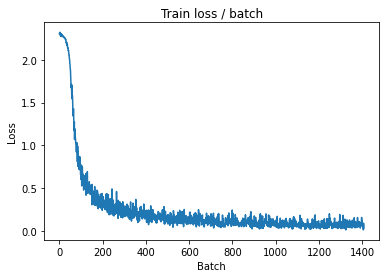

[TRAIN Batch 200/469]	Time 0.009s (0.008s)	Loss 0.1104 (0.0633)	Prec@1  96.1 ( 98.1)	Prec@5 100.0 (100.0)


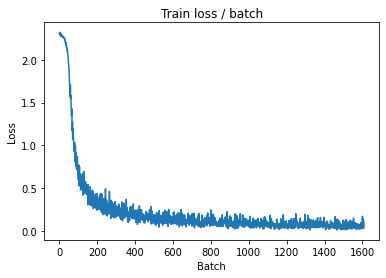

[TRAIN Batch 400/469]	Time 0.005s (0.007s)	Loss 0.0391 (0.0629)	Prec@1  98.4 ( 98.1)	Prec@5 100.0 (100.0)


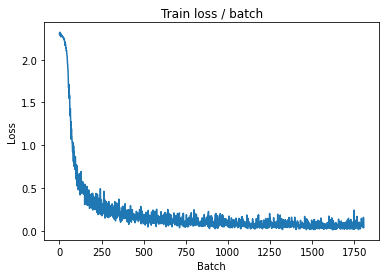


===============> Total time 3s	Avg loss 0.0620	Avg Prec@1 98.12 %	Avg Prec@5 99.97 %

[EVAL Batch 000/079]	Time 0.071s (0.071s)	Loss 0.0158 (0.0158)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)

===============> Total time 0s	Avg loss 0.0540	Avg Prec@1 98.27 %	Avg Prec@5 100.00 %



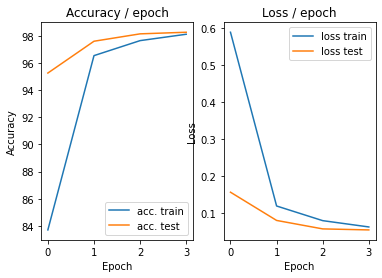

=== EPOCH 5 =====

[TRAIN Batch 000/469]	Time 0.074s (0.074s)	Loss 0.0612 (0.0612)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


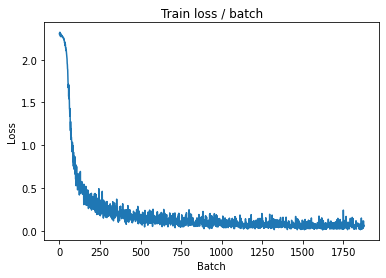

[TRAIN Batch 200/469]	Time 0.014s (0.008s)	Loss 0.0216 (0.0531)	Prec@1 100.0 ( 98.4)	Prec@5 100.0 (100.0)


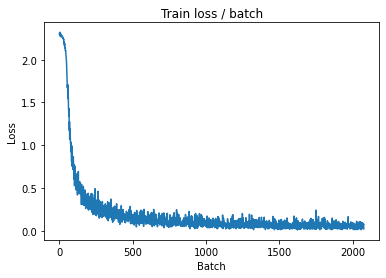

[TRAIN Batch 400/469]	Time 0.012s (0.008s)	Loss 0.0799 (0.0519)	Prec@1  97.7 ( 98.4)	Prec@5 100.0 (100.0)


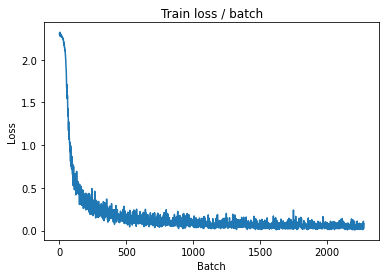


===============> Total time 4s	Avg loss 0.0519	Avg Prec@1 98.42 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 0.074s (0.074s)	Loss 0.0127 (0.0127)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)

===============> Total time 0s	Avg loss 0.0468	Avg Prec@1 98.51 %	Avg Prec@5 100.00 %



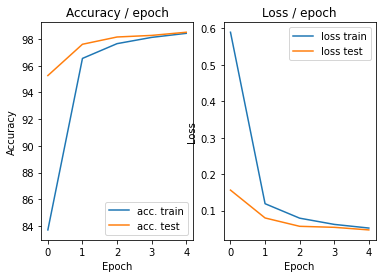

In [5]:
main(128, 0.1, cuda=True)